In [110]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
import os
import string
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xarray as xr

import torch
import torch.nn as nn
import joblib

In [2]:
pot_id = "100pct_3day-removed"
pot_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{pot_id}_outputs"

x_id = "x-cond-3day"
x_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{x_id}_outputs"

y_id = "y-cond-3day"
y_path = f"/home/sachin/Documents/NIPR/Research/Data/ML/MLP/{y_id}_outputs"

In [3]:
class MonteCarloDropout(nn.Dropout):
    def forward(self, input):
        return nn.functional.dropout(input, self.p, True, self.inplace)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 2056),
            nn.ReLU(),
            #MonteCarloDropout(0.2),
            nn.Linear(2056, 1024),
            nn.ReLU(),
            #MonteCarloDropout(0.2), 
	        nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            MonteCarloDropout(0.2), 
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [169]:
model_pot = MLP(10)
model_pot.load_state_dict(torch.load(f'{pot_path}/model_{pot_id}.pt'))
model_pot.eval()

model_x = MLP(10)
model_x.load_state_dict(torch.load(f'{x_path}/model_{x_id}.pt'))
model_x.eval()

model_y = MLP(10)
model_y.load_state_dict(torch.load(f'{y_path}/model_{y_id}.pt'))
model_y.eval()

MLP(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=2056, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2056, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): MonteCarloDropout(p=0.2, inplace=False)
    (11): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [170]:
#Load omni data
omni_data = pd.read_csv('/home/sachin/Documents/NIPR/Research/Data/OMNI/omni_hro_5min_1999-10.csv')
#omni_data = omni_data[omni_data['Timestamp_1min_omni'] == '1999-10-01 00:00:00']
omni_data = omni_data[omni_data['Timestamp_1min_omni'].between('1999-10-01 00:00:00', '1999-10-01 23:59:59')]
omni_data

,BY_GSE,BZ_GSE,flow_speed,proton_density,AE_INDEX,AL_INDEX,AU_INDEX,Timestamp_1min_omni,Timestamp_1hr_omni,F10.7,Kp,tilt_angle
0,1.84,0.66,485.000000,4.17,178,-100,79,1999-10-01 00:00:00,1999-10-01 00:00:00,121.900002,23,-0.115365
1,3.35,0.41,481.899994,4.51,178,-107,71,1999-10-01 00:05:00,1999-10-01 00:00:00,121.900002,23,-0.119096
2,3.26,0.45,480.899994,4.63,178,-100,78,1999-10-01 00:10:00,1999-10-01 00:00:00,121.900002,23,-0.122795
3,2.70,-1.26,480.000000,4.81,169,-89,80,1999-10-01 00:15:00,1999-10-01 00:00:00,121.900002,23,-0.126461
4,2.21,-1.06,475.100006,4.71,227,-151,76,1999-10-01 00:20:00,1999-10-01 00:00:00,121.900002,23,-0.130093
...,...,...,...,...,...,...,...,...,...,...,...,...
283,4.12,-1.18,435.399994,6.07,213,-138,75,1999-10-01 23:35:00,1999-10-01 23:00:00,121.900002,13,-0.103219
284,4.59,-1.28,441.600006,5.71,192,-121,70,1999-10-01 23:40:00,1999-10-01 23:00:00,121.900002,13,-0.107079
285,4.91,-0.91,439.899994,6.12,152,-97,55,1999-10-01 23:45:00,1999-10-01 23:00:00,121.900002,13,-0.110916
286,4.95,-0.75,439.200012,6.00,189,-112,78,1999-10-01 23:50:00,1999-10-01 23:00:00,121.900002,13,-0.114730


In [171]:
def split_to_df(df):

    df = df.copy()

    #filters
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10

    #change data types
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)

    #create grid of lat and lon
    lat = np.linspace(50, 90, 30) #30 intervals between 53.1° to 89.7°
    lon = np.linspace(1, 360, 80) #80 intervals between 1.6° to 357.6°

    lat_mesh, lon_mesh = np.meshgrid(lat, lon)
    lats = lat_mesh.flatten()
    lons = lon_mesh.flatten()

    #expand out df to lat and lon dims. Aka repeat values 
    expanded_df = pd.DataFrame({'lat': lats.repeat(len(df)), 
                                'lon': lons.repeat(len(df)),
                                'BY_GSE': np.tile(df['BY_GSE'], len(lat)*len(lon)),
                                'BZ_GSE': np.tile(df['BZ_GSE'], len(lat)*len(lon)),
                                'flow_speed': np.tile(df['flow_speed'], len(lat)*len(lon)),
                                'proton_density': np.tile(df['proton_density'], len(lat)*len(lon)),
                                'tilt_angle': np.tile(df['tilt_angle'], len(lat)*len(lon)),
                                'dt': np.tile(df['Timestamp_1min_omni'], len(lat)*len(lon)),
                                'F10.7': np.tile(df['F10.7'], len(lat)*len(lon)),
                                'Kp': np.tile(df['Kp'], len(lat)*len(lon)),
                                'AE_INDEX': np.tile(df['AE_INDEX'], len(lat)*len(lon)),
                                'AL_INDEX': np.tile(df['AL_INDEX'], len(lat)*len(lon)),
                                'AU_INDEX': np.tile(df['AU_INDEX'], len(lat)*len(lon))})

    expanded_df['mlt'] = np.mod(expanded_df['lon'] + 12, 360) / 15


    df_2 = expanded_df.copy()
    df_2 = df_2[['dt','mlt','lon','lat','BY_GSE','BZ_GSE','flow_speed','proton_density','tilt_angle']]

    df_2['mlt_sin'] = np.sin(df_2['mlt']*(2.*np.pi/24))
    df_2['mlt_cos'] = np.cos(df_2['mlt']*(2.*np.pi/24))

    df_2['lon_sin'] = np.sin((df_2['lon']-1)*(2.*np.pi/360))
    df_2['lon_cos'] = np.cos((df_2['lon']-1)*(2.*np.pi/360))

    df_2 = df_2.drop(columns=['dt'])

    return expanded_df, df_2

df_raw, df_proc = split_to_df(omni_data)
df_raw


,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt
0,50.0,1.0,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.866667
1,50.0,1.0,3.35,0.41,481,4.51,-0.119096,1999-10-01 00:05:00,121,2.3,178,-107,71,0.866667
2,50.0,1.0,3.26,0.45,480,4.63,-0.122795,1999-10-01 00:10:00,121,2.3,178,-100,78,0.866667
3,50.0,1.0,2.70,-1.26,480,4.81,-0.126461,1999-10-01 00:15:00,121,2.3,169,-89,80,0.866667
4,50.0,1.0,2.21,-1.06,475,4.71,-0.130093,1999-10-01 00:20:00,121,2.3,227,-151,76,0.866667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681595,90.0,360.0,4.12,-1.18,435,6.07,-0.103219,1999-10-01 23:35:00,121,1.3,213,-138,75,0.800000
681596,90.0,360.0,4.59,-1.28,441,5.71,-0.107079,1999-10-01 23:40:00,121,1.3,192,-121,70,0.800000
681597,90.0,360.0,4.91,-0.91,439,6.12,-0.110916,1999-10-01 23:45:00,121,1.3,152,-97,55,0.800000
681598,90.0,360.0,4.95,-0.75,439,6.00,-0.114730,1999-10-01 23:50:00,121,1.3,189,-112,78,0.800000


In [172]:
'''
with open(f'{pot_path}/scaler_{pot_id}.pkl', 'rb') as f:
    scaler = pickle.load(f)

col_names = df_proc.columns
norm_arr = scaler.transform(df_proc)
df_proc = pd.DataFrame(norm_arr, columns=col_names)
df_proc = df_proc.drop(columns=['mlt','lon'])
df_proc'''

"\nwith open(f'{pot_path}/scaler_{pot_id}.pkl', 'rb') as f:\n    scaler = pickle.load(f)\n\ncol_names = df_proc.columns\nnorm_arr = scaler.transform(df_proc)\ndf_proc = pd.DataFrame(norm_arr, columns=col_names)\ndf_proc = df_proc.drop(columns=['mlt','lon'])\ndf_proc"

In [173]:
def rescale(df, path, id):

    df = df.copy()
    
    with open(f'{path}/scaler_{id}.pkl', 'rb') as f:
        scaler = pickle.load(f)

    col_names = df.columns
    norm_arr = scaler.transform(df)
    df = pd.DataFrame(norm_arr, columns=col_names)
    df = df.drop(columns=['mlt','lon'])
    
    return df

df_pot = rescale(df_proc, pot_path, pot_id)
df_x = rescale(df_proc, x_path, x_id)
df_y = rescale(df_proc, y_path, y_id)

/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/home/sachin/miniconda3/envs/torch_env/lib/python3.12/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [174]:
def make_predictions(df, model):

    df = df.copy()

    df = df.to_numpy()
    
    df = torch.tensor(df, dtype=torch.float32)

    batch_size = 10000  # Adjust this value based on your system's memory capacity
    n = len(df)
    predictions = []

    for i in range(0, n, batch_size):
        batch = df[i:i+batch_size]
        batch_pred = model(batch).detach().cpu().numpy()
        batch_pred = batch_pred.flatten()
        predictions.extend(batch_pred)

    return predictions

pot_pred = make_predictions(df_pot, model_pot)
x_pred = make_predictions(df_x, model_x)
y_pred = make_predictions(df_y, model_y)

df_comp = df_raw
df_comp['pot_pred'] = pot_pred
df_comp['x_pred'] = x_pred
df_comp['y_pred'] = y_pred

In [10]:
'''
df_proc = df_proc.to_numpy()
df_proc = torch.tensor(df_proc, dtype=torch.float32)

batch_size = 10000  # Adjust this value based on your system's memory capacity
n = len(df_proc)
predictions = []

for i in range(0, n, batch_size):
    batch = df_proc[i:i+batch_size]
    batch_pred = model_pot(batch).detach().cpu().numpy()
    batch_pred = batch_pred.flatten()
    predictions.extend(batch_pred)

df_raw['potential_pred'] = predictions
df_comp = df_raw
df_comp'''

"\ndf_proc = df_proc.to_numpy()\ndf_proc = torch.tensor(df_proc, dtype=torch.float32)\n\nbatch_size = 10000  # Adjust this value based on your system's memory capacity\nn = len(df_proc)\npredictions = []\n\nfor i in range(0, n, batch_size):\n    batch = df_proc[i:i+batch_size]\n    batch_pred = model_pot(batch).detach().cpu().numpy()\n    batch_pred = batch_pred.flatten()\n    predictions.extend(batch_pred)\n\ndf_raw['potential_pred'] = predictions\ndf_comp = df_raw\ndf_comp"

In [175]:
def filter_by_dt(df):
   df = df.copy()
   #df = df[df['dt']=='1999-10-01 12:00:00']

   return df

df_filt = filter_by_dt(df_comp)
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt,pot_pred,x_pred,y_pred
0,50.0,1.0,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.866667,3.981415,1.826937,1.623086
1,50.0,1.0,3.35,0.41,481,4.51,-0.119096,1999-10-01 00:05:00,121,2.3,178,-107,71,0.866667,2.245231,1.850783,1.623088
2,50.0,1.0,3.26,0.45,480,4.63,-0.122795,1999-10-01 00:10:00,121,2.3,178,-100,78,0.866667,2.400989,1.853421,1.623088
3,50.0,1.0,2.70,-1.26,480,4.81,-0.126461,1999-10-01 00:15:00,121,2.3,169,-89,80,0.866667,2.354354,1.839911,1.623093
4,50.0,1.0,2.21,-1.06,475,4.71,-0.130093,1999-10-01 00:20:00,121,2.3,227,-151,76,0.866667,1.246793,1.852124,1.624136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681595,90.0,360.0,4.12,-1.18,435,6.07,-0.103219,1999-10-01 23:35:00,121,1.3,213,-138,75,0.800000,14.481576,1.627887,1.624136
681596,90.0,360.0,4.59,-1.28,441,5.71,-0.107079,1999-10-01 23:40:00,121,1.3,192,-121,70,0.800000,-3.653383,1.628156,1.628504
681597,90.0,360.0,4.91,-0.91,439,6.12,-0.110916,1999-10-01 23:45:00,121,1.3,152,-97,55,0.800000,3.149899,1.629421,1.628476
681598,90.0,360.0,4.95,-0.75,439,6.00,-0.114730,1999-10-01 23:50:00,121,1.3,189,-112,78,0.800000,3.871233,1.629062,1.627605


In [182]:
dx, dy = 1.37, 1
#grad x is north-south, grad y is east-west
#grad_x, grad_y = np.gradient(df_filt['pot_pred'].values.reshape(-1,30,80), dx, dy)

#loop through dt
for dt in df_filt['dt'].unique():
    df_dt = df_filt[df_filt['dt'] == dt]
    grad_x, grad_y = np.gradient(df_dt['pot_pred'].values.reshape(30,80), dx, dy)
    grad_x = grad_x.flatten()
    grad_y = grad_y.flatten()
    Ex = -grad_x
    Ey = -grad_y

    df_filt.loc[df_filt['dt'] == dt, 'Ex'] = Ex
    df_filt.loc[df_filt['dt'] == dt, 'Ey'] = Ey

    print(df_filt)
    #break

         lat    lon  BY_GSE  BZ_GSE  flow_speed  proton_density  tilt_angle  \
0       50.0    1.0    1.84    0.66         485            4.17   -0.115365   
1       50.0    1.0    3.35    0.41         481            4.51   -0.119096   
2       50.0    1.0    3.26    0.45         480            4.63   -0.122795   
3       50.0    1.0    2.70   -1.26         480            4.81   -0.126461   
4       50.0    1.0    2.21   -1.06         475            4.71   -0.130093   
...      ...    ...     ...     ...         ...             ...         ...   
681595  90.0  360.0    4.12   -1.18         435            6.07   -0.103219   
681596  90.0  360.0    4.59   -1.28         441            5.71   -0.107079   
681597  90.0  360.0    4.91   -0.91         439            6.12   -0.110916   
681598  90.0  360.0    4.95   -0.75         439            6.00   -0.114730   
681599  90.0  360.0    4.80   -1.68         441            6.33   -0.118517   

                         dt  F10.7   Kp  AE_INDEX  

In [183]:
df_filt.sort_values(by=['dt','lat','lon'], inplace=False)

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,AE_INDEX,AL_INDEX,AU_INDEX,mlt,pot_pred,x_pred,y_pred,Ex,Ey
0,50.0,1.000000,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,0.866667,3.981415,1.826937,1.623086,-1.275466,-0.673348
8520,50.0,5.544304,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,1.169620,3.298625,1.847424,1.623087,-0.434210,8.689149
17040,50.0,10.088608,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,1.472574,3.505172,1.852673,1.623081,-0.409820,11.435112
25560,50.0,14.632911,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,1.775527,2.666704,1.841240,1.623073,-5.195809,11.615574
34080,50.0,19.177215,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,178,-100,79,2.078481,1.417817,1.846875,1.624136,-3.813873,11.458746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647519,90.0,341.822785,4.80,-1.68,441,6.33,-0.118517,1999-10-01 23:55:00,121,1.3,195,-119,76,23.588186,-9.830942,1.628285,1.634518,2.579720,-4.823846
656039,90.0,346.367089,4.80,-1.68,441,6.33,-0.118517,1999-10-01 23:55:00,121,1.3,195,-119,76,23.891139,-8.156676,1.618905,1.642741,2.788539,-5.195803
664559,90.0,350.911392,4.80,-1.68,441,6.33,-0.118517,1999-10-01 23:55:00,121,1.3,195,-119,76,0.194093,-9.082446,1.638051,1.634613,4.074697,-3.952487
673079,90.0,355.455696,4.80,-1.68,441,6.33,-0.118517,1999-10-01 23:55:00,121,1.3,195,-119,76,0.497046,-7.824059,1.628176,1.638453,2.094646,-3.972222


In [184]:

#Ex = -grad_x
#Ey = -grad_y

#df_filt['Ex'] = Ex.flatten() #north-south
#df_filt['Ey'] = Ey.flatten()  #east-west
df_filt['sigma_xy'] = df_filt['x_pred'] * df_filt['y_pred']
df_filt['sigma_xx'] = df_filt['x_pred']**2
df_filt['sigma_yy'] = df_filt['y_pred']**2
df_filt['JHx'] = df_filt['sigma_xy'] * df_filt['Ey'] #east-west
df_filt['JHy'] = -df_filt['sigma_xy'] * df_filt['Ex'] #north-south
df_filt['JPx'] = df_filt['sigma_xx'] * df_filt['Ex']
df_filt['JPy'] = df_filt['sigma_yy'] * df_filt['Ey']
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,...,y_pred,Ex,Ey,sigma_xy,sigma_xx,sigma_yy,JHx,JHy,JPx,JPy
0,50.0,1.0,1.84,0.66,485,4.17,-0.115365,1999-10-01 00:00:00,121,2.3,...,1.623086,-1.275466,-0.673348,2.965277,3.337700,2.634408,-1.996662,3.782109,-4.257123,-1.773873
1,50.0,1.0,3.35,0.41,481,4.51,-0.119096,1999-10-01 00:05:00,121,2.3,...,1.623088,-2.297303,-0.356914,3.003983,3.425398,2.634413,-1.072162,6.901059,-7.869176,-0.940258
2,50.0,1.0,3.26,0.45,480,4.63,-0.122795,1999-10-01 00:10:00,121,2.3,...,1.623088,-5.146062,-0.329922,3.008264,3.435168,2.634413,-0.992492,15.480713,-17.677588,-0.869150
3,50.0,1.0,2.70,-1.26,480,4.81,-0.126461,1999-10-01 00:15:00,121,2.3,...,1.623093,-1.984345,-0.722453,2.986347,3.385272,2.634432,-2.157494,5.925944,-6.717548,-1.903252
4,50.0,1.0,2.21,-1.06,475,4.71,-0.130093,1999-10-01 00:20:00,121,2.3,...,1.624136,-1.553571,0.137098,3.008101,3.430363,2.637818,0.412404,4.673298,-5.329312,0.361639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681595,90.0,360.0,4.12,-1.18,435,6.07,-0.103219,1999-10-01 23:35:00,121,1.3,...,1.624136,-10.964631,1.718144,2.643910,2.650017,2.637818,4.542620,28.989502,-29.056456,4.532153
681596,90.0,360.0,4.59,-1.28,441,5.71,-0.107079,1999-10-01 23:40:00,121,1.3,...,1.628504,1.815325,1.717371,2.651459,2.650892,2.652027,4.553540,-4.813261,4.812231,4.554514
681597,90.0,360.0,4.91,-0.91,439,6.12,-0.110916,1999-10-01 23:45:00,121,1.3,...,1.628476,-6.395528,-2.705839,2.653472,2.655012,2.651933,-7.179868,16.970356,-16.980206,-7.175704
681598,90.0,360.0,4.95,-0.75,439,6.00,-0.114730,1999-10-01 23:50:00,121,1.3,...,1.627605,-6.892641,-1.030995,2.651470,2.653844,2.649097,-2.733652,18.275627,-18.291992,-2.731206


In [165]:
df_filt = df_filt.sample(frac=0.01)
df_filt

,lat,lon,BY_GSE,BZ_GSE,flow_speed,proton_density,tilt_angle,dt,F10.7,Kp,...,y_pred,Ex,Ey,sigma_xy,sigma_xx,sigma_yy,JHx,JHy,JPx,JPy
3095507,65.172414,232.759494,-2.94,1.25,428,9.41,-0.242350,1999-10-05 02:50:00,146,2.7,...,2.263479,-1.160073,-2.086860,5.752590,6.459128,5.123337,-12.004851,6.673424,-7.493060,-10.691689
3929334,58.275862,296.379747,-4.89,2.69,469,4.87,-0.024006,1999-10-06 21:10:00,133,1.0,...,2.294075,6.632173,0.234734,6.818759,8.834775,5.262780,1.600595,-45.223186,58.593754,1.235354
4035647,90.000000,300.924051,0.06,-0.20,497,5.93,-0.024312,1999-10-06 11:55:00,133,2.0,...,1.885986,3.272568,-7.438856,3.218290,2.911881,3.556942,-23.940397,-10.532072,9.529327,-26.459578
3157862,66.551724,237.303797,-1.47,-7.97,493,11.95,-0.025356,1999-10-05 11:45:00,146,3.3,...,4.282226,-0.698319,-0.984488,23.689049,30.602440,18.337460,-23.321596,16.542503,-21.370253,-18.053019
1207118,51.379310,91.886076,1.65,-1.53,419,6.93,-0.207166,1999-10-02 02:15:00,126,3.0,...,1.622217,-1.654774,-0.149200,2.941629,3.288197,2.631588,-0.438892,4.867733,-5.441225,-0.392634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198193,69.310345,164.594937,-4.87,0.94,510,3.96,-0.178615,1999-10-06 00:40:00,133,0.7,...,2.982613,2.239701,1.089417,9.971085,11.176117,8.895981,10.862664,-22.332249,25.031160,9.691428
4124772,69.310345,310.012658,2.04,-4.22,433,8.29,-0.241757,1999-10-02 04:45:00,126,3.3,...,1.650146,13.479115,-0.164975,2.740488,2.758108,2.722981,-0.452113,-36.939358,37.176853,-0.449224
1093040,55.517241,82.797468,-1.38,-4.16,404,4.61,-0.105966,1999-10-03 09:45:00,134,2.0,...,1.673065,-9.207765,1.819543,2.963073,3.136601,2.799145,5.391439,27.283281,-28.881086,5.093165
1365140,76.206897,100.974684,-4.41,1.30,467,3.74,-0.110044,1999-10-06 23:00:00,133,1.0,...,1.680543,4.330479,-1.906028,3.422875,4.148422,2.824224,-6.524096,-14.822687,17.964651,-5.383051


In [186]:
df_filt.describe().T

,count,mean,std,min,25%,50%,75%,max
lat,681600.0,70.000000,11.938549,50.000000,59.655172,70.000000,80.344828,90.000000
lon,681600.0,180.500000,104.938079,1.000000,90.750000,180.500000,270.250000,360.000000
BY_GSE,681600.0,2.410599,1.530262,-3.190000,1.537500,2.685000,3.472500,5.050000
BZ_GSE,681600.0,0.245141,1.407353,-3.310000,-0.750000,0.230000,1.195000,3.360000
flow_speed,681600.0,461.056338,14.594180,422.000000,451.000000,461.000000,471.000000,499.000000
proton_density,681600.0,4.389190,0.647842,2.780000,3.950000,4.320000,4.842500,6.330000
tilt_angle,681600.0,-0.051779,0.127042,-0.235091,-0.176390,-0.050953,0.074329,0.126912
F10.7,681600.0,121.000000,0.000000,121.000000,121.000000,121.000000,121.000000,121.000000
Kp,681600.0,2.122535,0.676611,1.300000,1.300000,1.700000,3.000000,3.000000
AE_INDEX,681600.0,230.422535,132.460100,55.000000,144.000000,192.000000,282.750000,804.000000


<Axes: xlabel='dt', ylabel='JHx'>

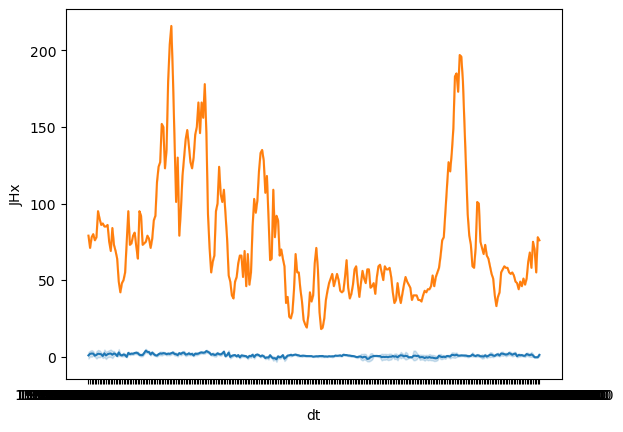

In [187]:
sns.lineplot(data=df_filt, x='dt', y='JHx')
sns.lineplot(data=df_filt, x='dt', y='AU_INDEX')

In [13]:
'''
sigma_xy = np.zeros((30,80))
J_x = np.zeros((30,80))
J_y = np.zeros((30,80))

x_sigma = np.array(x_pred).reshape(30,80)
y_sigma = np.array(y_pred).reshape(30,80)


for i in range(30):
    for j in range(80):
        sigma_xy[i,j] = x_sigma[i,j] * y_sigma[i,j] 

        J_x[i,j] = sigma_xy[i,j] * Ey[i,j]
        J_y[i,j] = -sigma_xy[i,j] * Ex[i,j]

df_filt['sigma_xy'] = sigma_xy.flatten()
df_filt['J_x'] = J_x.flatten()
df_filt['J_y'] = J_y.flatten()
df_filt'''

"\nsigma_xy = np.zeros((30,80))\nJ_x = np.zeros((30,80))\nJ_y = np.zeros((30,80))\n\nx_sigma = np.array(x_pred).reshape(30,80)\ny_sigma = np.array(y_pred).reshape(30,80)\n\n\nfor i in range(30):\n    for j in range(80):\n        sigma_xy[i,j] = x_sigma[i,j] * y_sigma[i,j] \n\n        J_x[i,j] = sigma_xy[i,j] * Ey[i,j]\n        J_y[i,j] = -sigma_xy[i,j] * Ex[i,j]\n\ndf_filt['sigma_xy'] = sigma_xy.flatten()\ndf_filt['J_x'] = J_x.flatten()\ndf_filt['J_y'] = J_y.flatten()\ndf_filt"

ValueError: 'x' must be strictly increasing

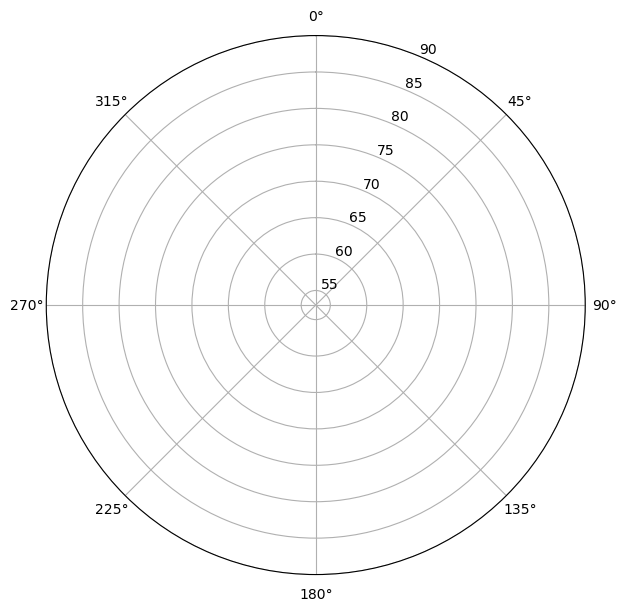

In [138]:
#quiver plot on polar projection
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_rlim(53, 90)

#plot quiver
ax.streamplot(df_filt['lon'], df_filt['lat'], df_filt['JPx'], df_filt['JPy'], color='r')


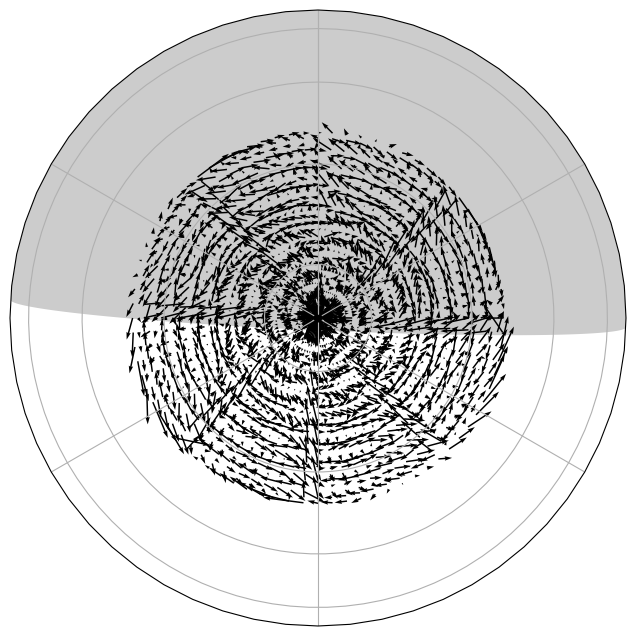

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade

def sample_data(shape=(30, 80)):
    """
    Returns ``(x, y, u, v, crs)`` of some vector data
    computed mathematically. The returned crs will be a PlateCarree CRS.

    """
    crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=90)

    lat = np.linspace(53, 90, shape[0])
    lon = np.linspace(0, 360, shape[1], endpoint=False)


    return lon, lat, crs

def main():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 90))

    #ax.add_feature(cartopy.feature.OCEAN, zorder=0)
    #ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

    ax.set_global()
    ax.gridlines()
    #ax.coastlines()
    #ax.set_extent([-180, 180, 53, 90], ccrs.PlateCarree())

    lon, lat, vector_crs = sample_data()
    ax.quiver(lon, lat, Ex, Ey, transform=vector_crs, scale=400)

    date = datetime.datetime(1999, 10, 1, 12)
    ax.add_feature(Nightshade(date, alpha=0.2))

    plt.show()

if __name__ == '__main__':
    main()
